<a href="https://colab.research.google.com/github/pavi-ninjaac/DeepLearningProjects/blob/main/Face_Emotion_Recognision/FER_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
#import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

#keras 
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.models import load_model
from sklearn.metrics import confusion_matrix

#keras layers
from keras.models import Sequential 
from keras.layers import Conv2D,MaxPooling2D,BatchNormalization,AveragePooling2D
from keras.layers import Flatten,Dropout,Dense

In [49]:
#read the dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataFiles/fer2013.csv')

print("the classs labels",data['emotion'].unique()) #7 classes
print("The shape of the dataset",data.shape)

data.head(4)

the classs labels [0 2 4 6 3 5 1]
The shape of the dataset (35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training


In [50]:
data['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [51]:
#pixcels are in str formate so need to read and convert it to numpy array

def generate_dataset(data):
  X_train,y_train,X_test,y_test,X_val,y_val = [],[],[],[],[],[]

  print("Collecting all data...................")
  for i in range(data.shape[0]):
    d = data.iloc[i,:]
    value = d['pixels'].split(' ')
    if (d['Usage'] == 'Training'):
      X_train.append(np.array(value,'float32'))
      y_train.append(d['emotion'])
    elif d['Usage'] =='PrivateTest':
      X_val.append(np.array(value,'float32'))
      y_val.append(d['emotion'])
    else:
      X_test.append(np.array(value,'float32'))
      y_test.append(d['emotion'])


  print("Converting to numpy array>>>>>>>>>>>>>>>>>>")
  #convert list to numpy array
  X_train = np.array(X_train,'float32')  
  y_train = np.array(y_train,'float32')  
  X_test = np.array(X_test,'float32')  
  y_test = np.array(y_test,'float32')
  X_val = np.array(X_val,'float32')  
  y_val = np.array(y_val,'float32')

  print("Normalizing the data>>>>>>>>>>>>>>>>>>>>>>")
  #normalize the data
  X_train  = X_train/255.0
  X_test = X_test/255.0
  X_val = X_val/255.0

  print("Converting target to one hot encoded values>>>>>>>>>>>>>>>>>>>>>>")
  #convert to numerical values to 0,1
  y_train = to_categorical(y_train,num_classes=7)
  y_test = to_categorical(y_test,num_classes=7)
  y_val = to_categorical(y_val,num_classes=7)

  print("reshaping the data>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
  #reshape the train X data to 48 x 48 picxels
  #the len of the given picxels is 2304 ------>(48*48)
  X_train = X_train.reshape(X_train.shape[0] , 48 ,48 , 1)
  X_test = X_test.reshape(X_test.shape[0] , 48 ,48 , 1)
  X_val = X_val.reshape(X_val.shape[0] , 48 ,48 , 1)

  print("Preprocessing  completed!!!!!!!!!! stay happy :)")
  return X_train,y_train,X_test,y_test,X_val,y_val

In [52]:
X_train,y_train,X_test,y_test,X_val,y_val = generate_dataset(data)

Converting to numpy array>>>>>>>>>>>>>>>>>>
Normalizing the data>>>>>>>>>>>>>>>>>>>>>>
Converting target to one hot encoded values>>>>>>>>>>>>>>>>>>>>>>
reshaping the data>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Preprocessing  completed!!!!!!!!!! stay happy :)


In [53]:
print("The size of the train data-------------------->",X_train.shape)
print("The size of the train target data------------->",y_train.shape)
print()
print("The size of the test data--------------------->",X_test.shape)
print("The size of the test target data-------------->",y_test.shape)
print()
print("The size of the validation data--------------->",X_val.shape)
print("The size of the validation target data-------->",y_val.shape)

The size of the train data--------------------> (28709, 48, 48, 1)
The size of the train target data-------------> (28709, 7)

The size of the test data---------------------> (3589, 48, 48, 1)
The size of the test target data--------------> (3589, 7)

The size of the validation data---------------> (3589, 48, 48, 1)
The size of the validation target data--------> (3589, 7)


# plot functions

In [54]:
def plot_confueion_matrix(y_test , y_pred , title = "Confusion Matrix"):
  classes = np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))

  cmap = plt.cm.Blues
  cm = confusion_matrix(y_test , y_pred)
  
  #plot the cm
  plt.figure(figsize=(7,7))
  plt.imshow(cm , interpolation='nearest' , cmap= cmap)
  plt.colorbar()
  thresh = cm.min() + (cm.max() - cm.min()) / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45,fontsize=10)
  plt.yticks(tick_marks, classes,fontsize = 10)

  plt.title(title)
  plt.xlabel('Predicted value')
  plt.ylabel('True values')

  plt.tight_layout()
  plt.show()
  #plt.save('path.ghb.png')


def plot_accuracy_loss_graph(result):
  plt.figure(figsize=(20,8))
  plt.subplot(1,2,1)

  plt.plot(result.history['accuracy'])
  plt.plot(result.history['val_accuracy'])
  plt.title('VGG Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  
  #plt.savefig('ResNet Model Loss.png')

  plt.subplot(1,2,2)

  plt.plot(result.history['loss'])
  plt.plot(result.history['val_loss'])
  plt.title('VGG  Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  #plt.savefig('ResNet Model Loss.png')


# building the model--->ALEXNET Architechture

In [55]:
#building the model
def VGGnet(input_shape , num_classes , ):
  model = Sequential()
  model.add(Conv2D(64, (5, 5), activation='relu', padding='same', input_shape=input_shape)) 
  model.add(Conv2D(64, (5, 5), activation='relu', padding='same', ))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))

  #model.add(Conv2D(64, (5, 5), activation='relu', padding='same', ))
  #model.add(BatchNormalization())
  #model.add(MaxPooling2D(pool_size=(2,2)))


  model.add(Conv2D(128, (3, 3), activation='relu',  padding='same', ))
  model.add(Conv2D(128, (3, 3), activation='relu', padding='same',))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))


  model.add(Conv2D(256, (3, 3), activation='relu', padding='same',))
  model.add(Conv2D(256, (3, 3), activation='relu',  padding='same',))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))


  model.add(Flatten())

  model.add(Dense(1024, activation='relu',))
  model.add(Dropout(0.2))
  model.add(Dense(1024, activation='relu', ))
  model.add(Dropout(0.2))
  model.add(Dense(num_classes, activation='sigmoid'))


  # compile model
  
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  #model summary
  print(model.summary())

  return model

In [56]:
model = VGGnet(input_shape = (48,48,1), num_classes = 7)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_3 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 128)       147584    
_________________________________________________________________
batch_normalization_4 (Batch (None, 24, 24, 128)      

In [57]:
# set callbacks
early_stoppping = EarlyStopping(monitor = 'val_loss',
                                min_delta = 0.001,
                                patience = 10,
                                restore_best_weights=True)

#set the global values
epoches = 70
batch_size = 64

#fit the model
history = model.fit(X_train, y_train,  
          batch_size=batch_size,  
          epochs=epoches,  
          verbose=1,  
          validation_data=(X_val, y_val),  
          shuffle=True) #final accuracy --> at epoch 70 -->449/449 [==============================] - 16s 36ms/step - loss: 0.0594 - accuracy: 0.9826 - val_loss: 2.5800 - val_accuracy: 0.5938

Epoch 1/70
449/449 [==============================] - 17s 37ms/step - loss: 2.6125 - accuracy: 0.2393 - val_loss: 1.7982 - val_accuracy: 0.2764
Epoch 2/70
449/449 [==============================] - 16s 37ms/step - loss: 1.6113 - accuracy: 0.3645 - val_loss: 1.5656 - val_accuracy: 0.4007
Epoch 3/70
449/449 [==============================] - 16s 36ms/step - loss: 1.4641 - accuracy: 0.4322 - val_loss: 1.4131 - val_accuracy: 0.4531
Epoch 4/70
449/449 [==============================] - 16s 35ms/step - loss: 1.3374 - accuracy: 0.4874 - val_loss: 1.6038 - val_accuracy: 0.3486
Epoch 5/70
449/449 [==============================] - 16s 35ms/step - loss: 1.2254 - accuracy: 0.5317 - val_loss: 1.3052 - val_accuracy: 0.4932
Epoch 6/70
449/449 [==============================] - 16s 36ms/step - loss: 1.1230 - accuracy: 0.5757 - val_loss: 1.4209 - val_accuracy: 0.4461
Epoch 7/70
449/449 [==============================] - 16s 36ms/step - loss: 1.0347 - accuracy: 0.6077 - val_loss: 1.2306 - val_accuracy:

In [58]:
# save model and architecture to single file
model.save("/content/drive/MyDrive/Colab Notebooks/dataFiles/FER_vggnet.h5")
print("Saved model to disk")

Saved model to disk


In [61]:
# load the model from the disk

fer_vggnet  = load_model('/content/drive/MyDrive/Colab Notebooks/dataFiles/FER_vggnet.h5')
fer_vggnet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_3 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 128)       147584    
_________________________________________________________________
batch_normalization_4 (Batch (None, 24, 24, 128)      

113/113 [==============================] - 1s 6ms/step


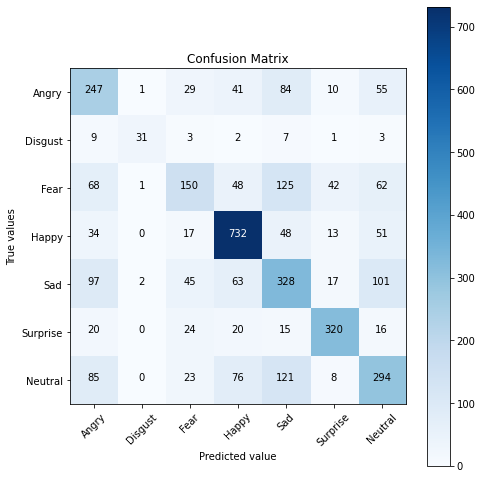

In [62]:
# plot the metrics

y_pred = fer_vggnet.predict(X_test , verbose=1)
y_pred = np.argmax(y_pred , axis = 1)

#change the test value to numerical
y_test = np.argmax(y_test , axis = 1)

plot_confueion_matrix(y_test = y_test , y_pred = y_pred)


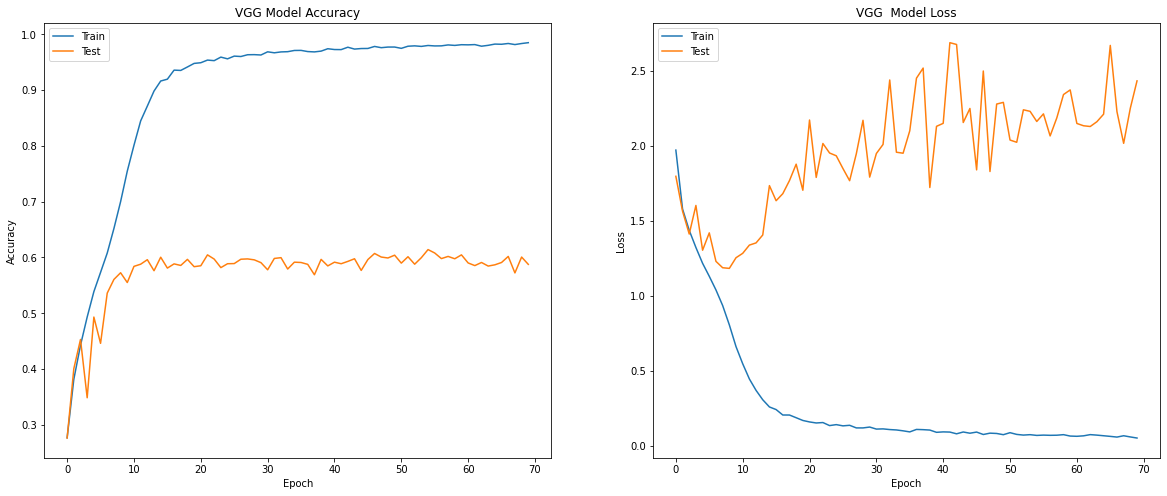

In [63]:
plot_accuracy_loss_graph(history)

In [ ]:
#testing with custom imgaes
